# MIE1624 Assignment #3

In [ ]:
# Import libraries
!pip install gensim
!pip install spacy
!spacy download en_core_web_sm
!pip install keras

In [1]:
import math
import html
import re
import string
import pandas as pd
import numpy as np
import nltk        
import gensim
import spacy 
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from nltk import word_tokenize  
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score, mean_absolute_error, confusion_matrix

In [2]:
# Check python version
import sys 
print(sys.version)

3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 1: Data Cleaning

### Loading dataset:
By briefly examining features and observations. This data set contains 550391 observations and 3 features. Target variable is 'label' column and it contains 2 classes with 0 being negative sentiment and 1 being positive sentiment.



In [3]:
# Load data
# path = '/content/drive/MyDrive/Colab Notebooks/1624 A3/sentiment_analysis.csv'
raw_df = pd.read_csv("sentiment_analysis.csv")
# raw_df = pd.read_csv(path)
print(raw_df.shape)
raw_df.head()

(550391, 3)


,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


### Following steps in this exact order are performed to sanitize data:  

* Checking if data contains null or NaN, replace them with empty string if found
* Remove emoji
* Remove URLS
* Remove twitter user name and tag starting with "RT @" or "RT@" or "@"
* Set text to lowercase
* Remove HTML tage and attributes due to parsing 
* Replace HTML char with ASCII equivalent
* Remove punctuation
* Lemmatize text to get root forms before removing stop words, spacy lemmatizing library is chosen as it can produce a descent result without needing to specify properties of each word. It gives a better result comparing to nltk in this case after some manual exploration.
* Remove stop words using Gensin stop words list
* Remove numbers as it is difficult to interpret the meaning/sentiment of a number without contexts

Finally the precessed text are stored in a new column named 'clean_txt'


In [ ]:
# Check nulls in data
print(raw_df.isnull().sum())
# Check if any text is empty string
np.where(raw_df['text'].apply(lambda x: x == ''))
# Add len column for data visualization
raw_df['length'] = raw_df['text'].apply(len)

ID       0
text     0
label    0
dtype: int64


In [16]:
# Clean text data
remove_html_tag = re.compile('<.*?>')
emoji_regex = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)

def sanitize_txt(text):

    # remove iOS emoji
    text = text.encode('latin-1', 'ignore').decode('latin-1')

    # remove urls      
    text = re.sub(r'(http|https|ftp)\S+', ' ', text)
    
    # remove twitter user name by @ or RT @
    text = re.sub('(RT |RT||)@[^\s]+','', text)
    
    # set to lowercase
    text = text.lower()
    
    # remove html tags and attributes
    text = re.sub(remove_html_tag, '', text)
    
    # remove html character codes and replaced with ASCII equivalent
    text = html.unescape(text)

    # remove emojis
    text = re.sub(emoji_regex, ' ',text)
    
    # # remove rt
    # text = text.replace('rt ', ' ')
    
    # remove puctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # lemmatize text
    text = lemmatizing(text)

    # remove stop words (gensin)
    text = remove_stopwords(text.lower())
    text = text.replace('-pron-', '')
    
    # remove all numbers as it is hard to interpret a meaning without context
    text = re.sub('\d+', ' ', text)

    return text

nlp = spacy.load('en_core_web_sm')
def lemmatizing(text):
    doc = nlp(text) 
    tokens = [token for token in doc] 
    lemmatized_sentence = ' '.join([token.lemma_ for token in doc]) 
    return lemmatized_sentence

In [ ]:
# !!! Note that this code snippet takes bit longer to run !!! 
# Process text and store the result in a new column named clean_txt
raw_df['clean_txt'] = raw_df['text'].apply(sanitize_txt)

In [ ]:
# Final dataset after text processing
raw_df

,ID,text,label,length,clean_txt
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1,114,josh jenkins look forward tab breeder crown su...
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1,140,congratulation pakistan no testteam world odd ...
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1,140,september maine mendozas surprise thanksgivin...
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1,139,newly paint wall thank million custodial pain...
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1,130,excite announce july feschotte lab relocate mbg
...,...,...,...,...,...
550386,8.046170e+17,@goddesses_o I can't stop watching her...mm. M...,0,76,stop watch hermm
550387,8.046180e+17,Poor old Tom Odell doesn't look like he would ...,0,96,poor old tom odell look like know wrong crowd
550388,8.046180e+17,#antsmasher I smashed 7 ants in this awesome ...,1,107,antsmasher smash ant awesome gamehjfjfi
550389,8.046180e+17,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1,130,morning girl wonderful friday


### Saving processed data into CSV  

Since our dataset is huge and text processing takes more than 1 hour, the processed text is saved as a csv so it can be loaded easiler everytime.

In [ ]:
# Save to google drive
# raw_df.to_csv('/content/drive/MyDrive/Colab Notebooks/1624 A3/processed_text_data.csv', index=False)

# Save to local
# raw_df.to_csv('processed_text_data.csv', index=False)

In [3]:
# raw_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1624 A3/processed_text_data.csv')
# raw_df

,ID,text,label,length,clean_txt
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1,114,josh jenkins look forward tab breeder crown su...
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1,140,congratulation pakistan no testteam world odd ...
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1,140,september maine mendozas surprise thanksgivin...
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1,139,newly paint wall thank million custodial pain...
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1,130,excite announce july feschotte lab relocate mbg
...,...,...,...,...,...
550386,8.046170e+17,@goddesses_o I can't stop watching her...mm. M...,0,76,stop watch hermm
550387,8.046180e+17,Poor old Tom Odell doesn't look like he would ...,0,96,poor old tom odell look like know wrong crowd
550388,8.046180e+17,#antsmasher I smashed 7 ants in this awesome ...,1,107,antsmasher smash ant awesome gamehjfjfi
550389,8.046180e+17,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1,130,morning girl wonderful friday


### Checking if any processed text contains NaN or Null and replaced them with empty string.
After sanitize text data, some observations are left as NaN, instead of removing them, they are filled in with empty string

In [4]:
print('-------Count of Null---------------------')
print(raw_df.isnull().sum())
# raw_df[raw_df['clean_txt'].isnull()]
print('-------Fill in NaN as empty string-------')
raw_df['clean_txt'] = raw_df['clean_txt'].fillna('')
print(raw_df.isnull().sum())

-------Count of Null---------------------
ID             0
text           0
label          0
length         0
clean_txt    781
dtype: int64
-------Fill in NaN as empty string-------
ID           0
text         0
label        0
length       0
clean_txt    0
dtype: int64


## Part 2: Exploratory Analysis
### Loading Canadian Election 2019 data

Data set contains 2133 observations and 3 features, target variable is sentiment which contains 2 classes: negative and positive. There is also one column indicating reasons for being negative sentiment.

In [4]:
# Load canadian election data
# path_election = '/content/drive/MyDrive/Colab Notebooks/1624 A3/Canadian_elections_2019.csv'
election_df = pd.read_csv("Canadian_elections_2019.csv")
# election_df = pd.read_csv(path_election)
print(election_df.shape)
election_df.head()

(2133, 3)


,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


In [13]:
# Check nulls
election_df.isnull().sum()

sentiment             0
negative_reason    1126
text                  0
dtype: int64

### Classifying each tweets from Canadian Election 2019 dataset into political parties

Before processing text in Canadian Election 2019 dataset, we can classify tweets into three Canadian political parties including liberal, conservative and NDP.

I designed a very simple algorithm to classify text into political parties. For each party, a list of keywords including party name, candidate name (first name and last name separately) and party campaign hashtag (such as #cpc, #lpc and #ndp) is generated. Then for each tweet text, I compute a dictionary contains counts of keywords that appears for each party. If all counts are zero, tweet will be classified as other parties, otherwise it will be classified to the party with max keywords counts. 

This algorthim is has limitations because it does not consider contexts where keywords appear, for example, there are tweets containing 'Sheer lie' or 'Tredeau go back' which will be classifies as conservative and liberal while they are actually negative comments about those parties. However, for a generic classification for visulization purpose, this algorithm should be enough.

Keywords lists for each party are the same length to ensure comparable counts.

In [14]:
# Liberal: Justin Trudeau
# Conservative: Andrew Scheer
# NDP: Jagmeet Singh
# #cpc, #lpc, #ndp, #gpc and #bq

lp = ['liberal', 'justin', 'trudeau', '#lpc']
cp = ['conservative', 'andrew', 'scheer', '#cpc']
ndp = ['#ndp', 'democratic', 'jagmeet', 'singh']

def which_party(txt):
    party = {}
    txt = txt.lower()
    
    party['liberal'] = sum(keyword in txt for keyword in lp)
    party['conservative'] = sum(keyword in txt for keyword in cp)
    party['ndp'] = sum(keyword in txt for keyword in ndp)

    if sum(party.values()) == 0:
        return 'other'
    else:
        return max(party, key=party.get)

# Apply this algorithm to classify a political party for each tweet
election_df['party'] = election_df['text'].apply(which_party)      

### Process text in Canadian Election 2019 Dataset for later use

Canadian Election 2019 dataset is processed the same way as sentiment_analysis data

In [17]:
# Text processing Canadian Election 2019 data
election_df['clean_txt'] = election_df['text'].apply(sanitize_txt)

# Set NaN to empty string
print(election_df.isnull().sum())
print('-------Fill in NaN as empty string---------------')
election_df['clean_txt'] = election_df['clean_txt'].fillna('')
print(election_df.isnull().sum())

sentiment             0
negative_reason    1126
text                  0
party                 0
clean_txt             0
dtype: int64
-------Fill in NaN as empty string---------------
sentiment             0
negative_reason    1126
text                  0
party                 0
clean_txt             0
dtype: int64


### Distribution of political affiliations of the tweets

This figure below visualizes distribution of political parties in Canadian election 2019 dataset. As well as positive/negative sentiment counts for each party. It reflects the fact that conservative party and liberal party are the two biggest political parties in Canada as they have the most tweets counts. However, there seem to be more negative tweets about conservative party comparing to liberal party, which interestingly aligns with liberal party won election in 2019 (Both in terms of seats and popular votes). There are still around 1000 tweets discussing the election without showing a political stand in these three parties. Other than discussing the other parties, many of them just simply encourage more people to vote or discussing political related topics such as healthcare, separation and climate etc. Although less tweets are related to NDP, it has the highest positive tweets ratio as shown in the histogram.

Text(0.5, 1.0, 'Political Parties Tweets Counts in Canadian Election 2019 with Sentiments')

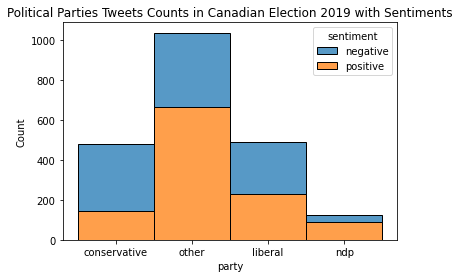

In [ ]:
# Count plot of each party in Canadian election dataframe and sentiments
sns.histplot(data=election_df, x="party", hue="sentiment", multiple="stack")
plt.title('Political Parties Tweets Counts in Canadian Election 2019 with Sentiments')

### Visual representation of generic tweets dataset and Canadian Election 2019 dataset

#### Generic tweets dataset:  

The first figure belows shows that generic dataset contains more positive(1) tweets than negative tweets(0) and total counts of positive tweets are around twice of negative ones. Hence generic tweets dataset is imbalanced.

The second figure shows relationship betweet positive and negative tweets and length of tweets. An interesting observation is that more tweets tend to be positive for longer length.

Text(0.5, 1.0, 'Negative(0)/Positive(0) Tweets Count in Generic Tweets Dataset')

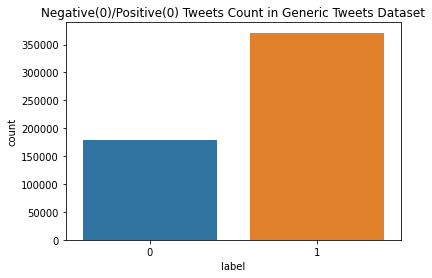

In [ ]:
# Count plot of sentiment in generic tweet dataset
sns.countplot(x='label', data=raw_df)
plt.title('Negative(0)/Positive(0) Tweets Count in Generic Tweets Dataset')

Text(0.5, 1.0, 'Negative(0)/Positive(1) Tweets Length Distribution')

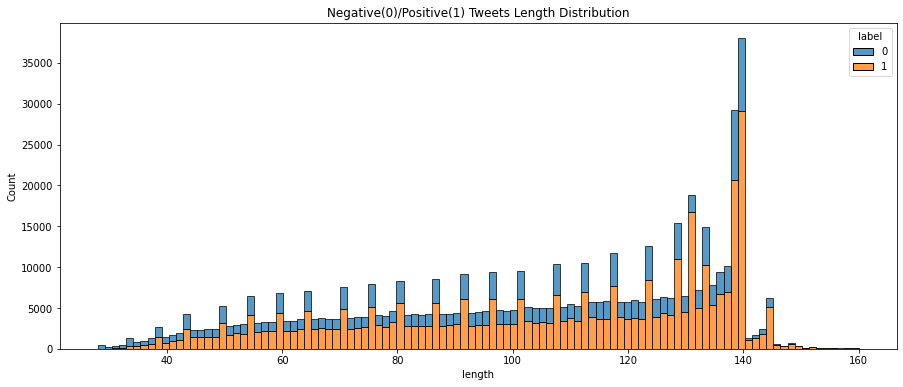

In [ ]:
plt.figure(figsize=(15, 6))
sns.histplot(data=raw_df, x="length", hue="label", multiple="stack")
plt.title('Negative(0)/Positive(1) Tweets Length Distribution')

#### Canadian Election 2019 dataset

The first figure belows shows the percentage of tweets for each party in Canadian Election 2019 dataset. As we can see, Liberal party and Conservative are pretty close in terms of percentage which are 23% and 22.5% respectively. This in fact reflects the actual 2019 election popular votes result where Liberal got 33.12% and Conservative 34.34%. Hence, information gathered on twitter can reflect people's political stand and futhermore to predict the votes. 

The second figure shows sentiment distribution for Canadian Election 2019 dataset. Counts of each sentiment are almost the same, which indicates people's sentiment for election and political parties overall is balanced.

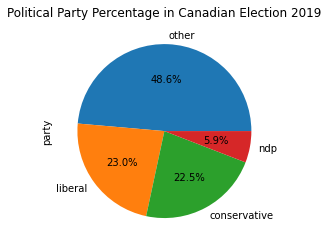

Text(0.5, 1.0, 'Sentiment Distribution in Canadian Election 2019')

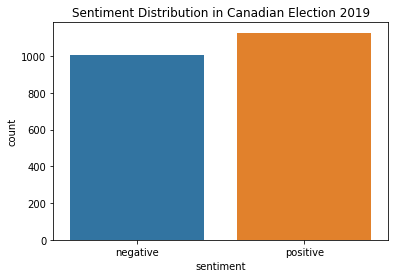

In [ ]:
# Pie plot of each party in Canadian election data to visualize percentage of parties in dataset
election_df['party'].value_counts().plot.pie( autopct='%1.1f%%')
plt.title('Political Party Percentage in Canadian Election 2019')
plt.show()

sns.countplot(x='sentiment', data=election_df)
plt.title('Sentiment Distribution in Canadian Election 2019')

### Bonus

Visualizing both datasets using word cloud. Word cloud library is used to compute the most frequent words after lemmatizing and removing stop words. 100 words maximum are selected for each dataset.  

In generic tweets dataset, the most frequent words are good, love, happy, great and thank etc. which all carry positive sentiment in common sense. This also aligns with distribution plot above which shows that counts of positive tweets are almost twice times of negative tweets.

In Canadian Election dataset, the most frequent words are exln which is offical twitter hashtag for election, cdnpoli, and leader name from both conservative party and liberal party. This also aligns with our previous political party tweets count distribution where conservative and liberal are the two most discussed individual political parties. 

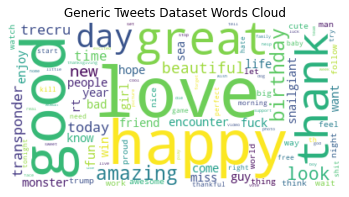

In [ ]:
# Generate word cloud
from wordcloud import WordCloud, STOPWORDS

wordscloud_txt = ' '.join(txt for txt in raw_df['clean_txt'])
wordcloud = WordCloud(collocations=False, max_words=100, background_color="white").generate(wordscloud_txt)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Generic Tweets Dataset Words Cloud')
plt.show()

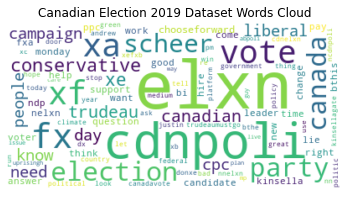

In [ ]:
wordscloud_txt = ' '.join(txt for txt in election_df['clean_txt'])
wordcloud = WordCloud(collocations=False, max_words=100, background_color="white").generate(wordscloud_txt)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Canadian Election 2019 Dataset Words Cloud')
plt.show()

## Part 3: Model Preparation

### 3.1 Vectorization and PCA

Split the dataset into 70% training and 30% testing before fitting any vectorizer and PCA, because test set need to be hidden when trainning in order to evaluate how generialize our models are. When evaluating how models perform on test set, these trained vectorizer and PCA models will be used only to transform test dataset. Following steps are implemented:

* **Vectorization**  
Two different vectorization methods are explored: bag of words and TF-IDF. 
I fit both vectorizer models using trainning set and then use these trained vectorizer models to transform testing set in order to get more representive result. Max_features is set to 1500 to limit max number of words it can select. Also, I add another constraint that selected words must not be too general that it appears in over 90% of the observations and it cannot be to rare that only appears in less than 50 observations.

* **Feature Importance**  
A correlation heatmap is plotted to demonstrate importance of selected words.

* **PCA**  
Because we got 1500 features from vectorization, in order to reduce complexity and improve computational efficiency, PCA is used to reduce dimensionality. 50 principal components are selected after PCA.
Before proceeding with PCA, data is standardized since normalization is required by PCA algorithm. Then, two PCA models are trained on bag of words vectorized embeddings and TF-IDF vertorized embeddings seperatly and respective PCA model is used to transform test data. 
Trade off of using PCA to reduce dimensionality is that some information will be lost and this will compromise model prediction power slightly. But in order to reduce run time of each algorithm, I needed PCA to increase computational efficiency.

In [5]:
# Splt data into training and testing
X = raw_df['clean_txt']
y = raw_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [10]:
# Bag of words embedding
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, min_df=50, max_df=0.9, stop_words='english')
X_train_wf = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names())
print(len(vectorizer.get_feature_names()))

['able', 'absolute', 'absolutely', 'abt', 'abuse', 'accept', 'accident', 'account', 'accurate', 'accuse', 'achieve', 'achievement', 'act', 'action', 'actor', 'actress', 'actual', 'actually', 'ad', 'add', 'admit', 'adopt', 'adorable', 'adult', 'adventure', 'advice', 'af', 'affect', 'afraid', 'african', 'afternoon', 'age', 'ago', 'agree', 'ahead', 'air', 'album', 'aldub', 'aldublolasinconcert', 'alive', 'allow', 'ama', 'amazing', 'amazon', 'america', 'american', 'americans', 'anal', 'android', 'angel', 'angry', 'animal', 'anniversary', 'announce', 'annoying', 'answer', 'anxiety', 'anymore', 'app', 'apparently', 'apple', 'appreciate', 'appreciation', 'architecture', 'area', 'arm', 'army', 'arrest', 'arrive', 'art', 'article', 'artist', 'asaram', 'ask', 'ass', 'asshole', 'attack', 'attend', 'attention', 'august', 'austin', 'australia', 'author', 'autumn', 'available', 'avoid', 'award', 'away', 'awesome', 'awful', 'aww', 'babe', 'baby', 'bad', 'bae', 'bag', 'ball', 'ban', 'band', 'bank', 'b

Compute feature importance by calculating correlations between each words and sentiment lable. Selected top 200 words from bag of words vectorizer.

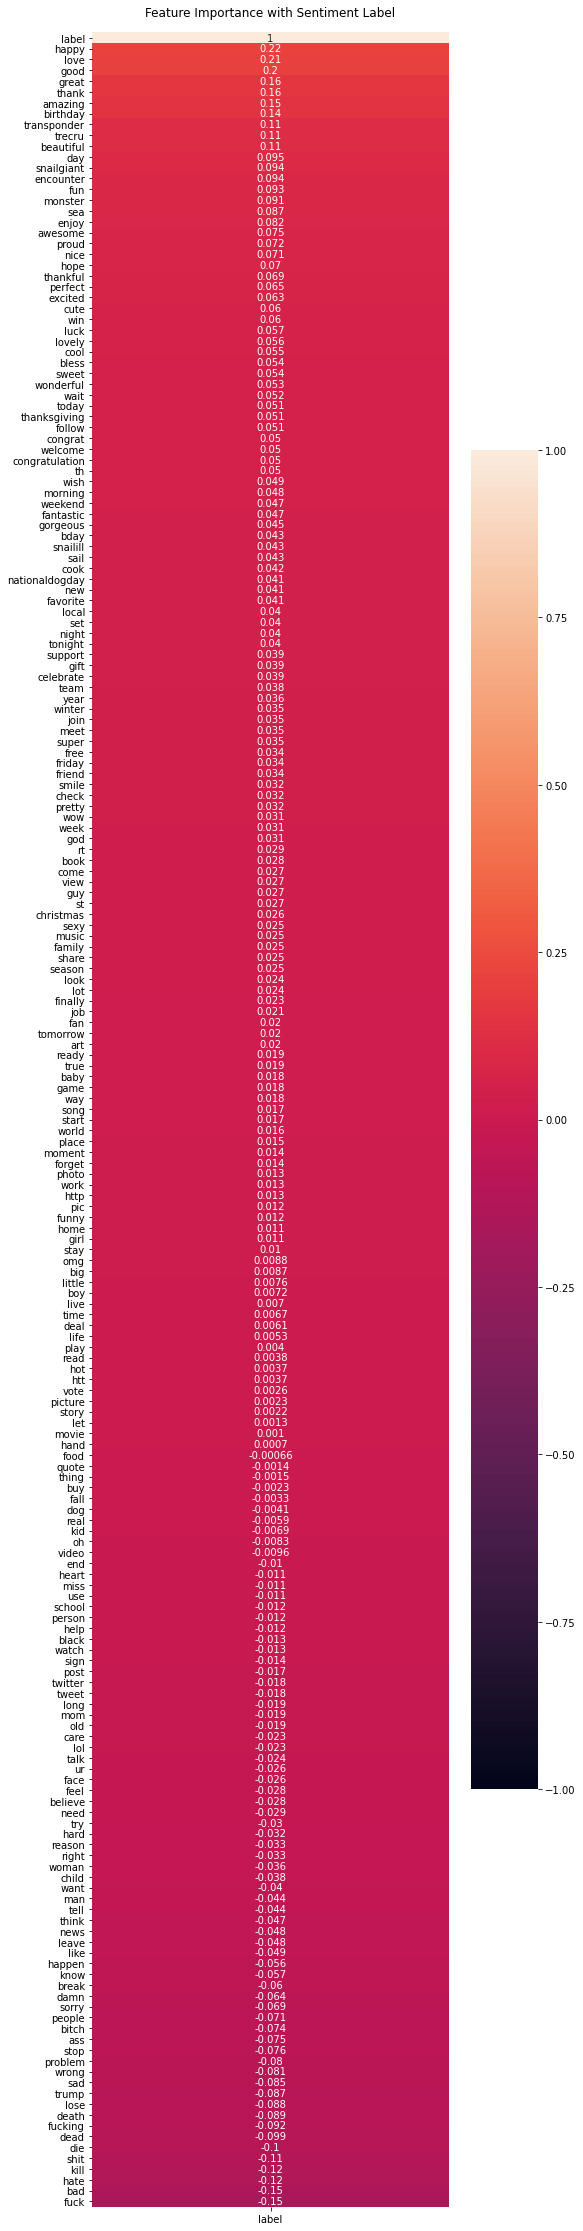

In [9]:
# Feature importance regarding Sentiment Label
fi_df = pd.DataFrame(X_train_wf.toarray(), columns = vectorizer.get_feature_names())
fi_df.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
fi_df = pd.concat([fi_df, y_train], axis=1)

plt.figure(figsize=(8,40))
heatmap = sns.heatmap(fi_df.corr()[['label']].sort_values(by='label', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Feature Importance with Sentiment Label', pad=16);

In [ ]:
# Standarize data before performing PCA as it requires features to be normalized
from sklearn.preprocessing import StandardScaler
scaler_wf = StandardScaler()
tmp = scaler_wf.fit_transform(X_train_wf.toarray())
wf_df = pd.DataFrame(tmp, columns = vectorizer.get_feature_names())
# wf_df = pd.DataFrame(wf_df, columns = vectorizer.get_feature_names())

In [ ]:
# Bag of words PCA
from sklearn.decomposition import PCA
pca_wf = PCA(n_components=50)
pca_wf_df = pca_wf.fit_transform(wf_df)
# print(pca_wf.explained_variance_())

In [ ]:
# TF-IDF embedding
from sklearn.feature_extraction.text import TfidfVectorizer
tfIdfVectorizer = TfidfVectorizer(use_idf=True, max_features=1500, min_df=50, max_df=0.9)
X_train_tfidf = tfIdfVectorizer.fit_transform(X_train)
print(tfIdfVectorizer.get_feature_names())
print(len(tfIdfVectorizer.get_feature_names()))

['able', 'absolute', 'absolutely', 'abt', 'abuse', 'accept', 'accident', 'account', 'accurate', 'accuse', 'achieve', 'achievement', 'act', 'action', 'actor', 'actress', 'actual', 'actually', 'ad', 'add', 'admit', 'adopt', 'adorable', 'adult', 'adventure', 'advice', 'af', 'affect', 'afraid', 'african', 'afternoon', 'age', 'ago', 'agree', 'ahead', 'air', 'album', 'aldub', 'aldublolasinconcert', 'alive', 'allow', 'am', 'ama', 'amazing', 'amazon', 'america', 'american', 'americans', 'anal', 'android', 'angel', 'angry', 'animal', 'anniversary', 'announce', 'annoying', 'answer', 'anxiety', 'anymore', 'app', 'apparently', 'apple', 'appreciate', 'appreciation', 'architecture', 'area', 'arm', 'army', 'arrest', 'arrive', 'art', 'article', 'artist', 'asaram', 'ask', 'ass', 'asshole', 'attack', 'attend', 'attention', 'august', 'austin', 'australia', 'author', 'autumn', 'available', 'avoid', 'award', 'away', 'awesome', 'awful', 'aww', 'babe', 'baby', 'bad', 'bae', 'bag', 'ball', 'ban', 'band', 'ban

In [ ]:
# Standarize data before performing PCA as it requires features to be normalized
tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns = tfIdfVectorizer.get_feature_names())
scaler_tfidf = StandardScaler()
tfidf_df = scaler_tfidf.fit_transform(tfidf_df)

# TF-IDF PCA
pca_tfidf = PCA(n_components=50)
pca_tfidf_df = pca_tfidf.fit_transform(tfidf_df)

Process testing set in the same processing order of training set

In [ ]:
# Process Testing set vectorization -> standardize -> PCA
x_test_wf = vectorizer.transform(X_test)
x_test_wf_df = pd.DataFrame(x_test_wf.toarray(), columns = vectorizer.get_feature_names())
tmp = scaler_wf.transform(x_test_wf_df)
pcax_test_wf_df = pca_wf.transform(tmp)

x_test_tfidf = tfIdfVectorizer.transform(X_test)
x_test_tfidf_df = pd.DataFrame(x_test_tfidf.toarray(), columns = tfIdfVectorizer.get_feature_names())
tmp = scaler_tfidf.transform(x_test_tfidf_df)
pca_x_test_tfidf_df = pca_tfidf.transform(tmp)

### 3.2 Building Models

In this section, I explored 7 models and for each model both bag of words and TF-IDF embeddings are implemented. Due to computational power limitations, each model is only manually tuned.

Here is the list of models and configurations:
* Logistic Regression with L2 penalty and lbfgs solver
* kNN with 5 neighbours
* Multinomial Naive Bayes, it is trained without PCA as PCA results negative data
* Linear SVM, linear kernal is selected due to huge dataset and dual set to false because n of samples is much bigger than n of features
* Decision tree with max depth of 12
* Random forest with max depth of 25
* XGBoost with 20 estimators, learning rate of 0.5 and max depth of 15

For each model, accuracy on training set and testing set, MSE on testing set and classification report are printed. 

Accuracy and MSE on testing set for each model with both embedding methods is shown below:

| Model               | Embedding Method | Accuracy on Test| MSE on Test|
| ------------        | ---------------- | --------------- |------------|
| Logistic Regression | Word Frequency   |0.8414           |0.1585      |
| Logistic Regression | TF\-IDF          |0.8373           |0.1627      |
| kNN                 | Word Frequency   |0.8789           |0.2111      |
| kNN                 | TF\-IDF          |0.8659           |0.1341      |
| Naive Bayes         | Word Frequency   |0.9128           |0.0872      |
| Naive Bayes         | TF\-IDF          |0.9011           |0.0989      |
| SVM                 | Word Frequency   |0.8382           |0.1618      |
| SVM                 | TF\-IDF          |0.8367           |0.1633      |
| Decision Tree       | Word Frequency   |0.8703           |0.1296      |
| Decision Tree       | TF\-IDF          |0.8556           |0.1444      |
| Random Forest       | Word Frequency   |0.9094           |0.0905      |
| Random Forest       | TF\-IDF          |0.8942           |0.1058      |
| XGBoost             | Word Frequency   |0.8956           |0.1044      |
| XGBoost             | TF\-IDF          |0.8896           |0.1104      |

The best model is random forest as it achieved accuracy of 90.94% with bag of words vectorizer. Although Navie Bayes achieved 91.28%, however it is not an apple to apple comparision as data fed into Naive Bayes is not PCA transformed due to negative values. Since even dimension reduced data can still achieve 90.94% on random forest, it is selected as the best model. As for the comparision between bag of words and TF-IDF vectorizers, it is observed that the accuracy is indifferent pretty much for all algorithms. And TF-IDF tends to have slightly lower accuracy in most of cases in this analysis. This might be because after applying standardization and PCA to reduce dimensionalities, words importance and frequency factors become less significant. Therefore no significant difference is observed in this result. It could also be caused by varaibility of models since cross validation is not implemented.

The best model selected after considering both testing accuracy and MSE is random forest with bag of words vectorizer. It will be used to predict sentiment for Canadian Election 2019 dataset in the next section.

#### 3.2.1 Logistic Regression Model
* Bag of words

In [ ]:
# Logistic Regression for Bag of words
lr_wf = LogisticRegression(random_state=7, penalty='l2', solver='lbfgs', max_iter=500)
lr_wf.fit(pca_wf_df, y_train)
y = lr_wf.predict(pcax_test_wf_df)
print('Logistic Regression Model - Bag of Words Embeddings')
print('---------------------------------------------------')
print('Training set accuracy: {}'.format(lr_wf.score(pca_wf_df, y_train)))
print('Testing set accuracy:  {}'.format(accuracy_score(y_test, y)))
print('Testing set MSE:       {}'.format(mean_squared_error(y_test, y)))
print('Classification report')
print('---------------------------------------------------')
print(classification_report(y_test, y))

Logistic Regression Model - Bag of Words Embeddings
---------------------------------------------------
Training set accuracy: 0.8390699581854945
Testing set accuracy:  0.841458835499461
Testing set MSE:       0.158541164500539
Classification report
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.68      0.74     53892
           1       0.85      0.92      0.89    111226

    accuracy                           0.84    165118
   macro avg       0.83      0.80      0.81    165118
weighted avg       0.84      0.84      0.84    165118



* TF-IDF

In [ ]:
# Logistic Regression for TF-IDF
lr_tfidf = LogisticRegression(random_state=7, penalty='l2', solver='lbfgs', max_iter=500)
lr_tfidf.fit(pca_tfidf_df, y_train)
y = lr_tfidf.predict(pca_x_test_tfidf_df)

print('Logistic Regression Model - TF-IDF')
print('---------------------------------------------------')
print('Training set accuracy: {}'.format(lr_tfidf.score(pca_tfidf_df, y_train)))
print('Testing set accuracy:  {}'.format(accuracy_score(y_test, y)))
print('Testing set MSE:       {}'.format(mean_squared_error(y_test, y)))
print('Classification report')
print('---------------------------------------------------')
print(classification_report(y_test, y))

Logistic Regression Model - TF-IDF
---------------------------------------------------
Training set accuracy: 0.8341098389972824
Testing set accuracy:  0.8373163434634625
Testing set MSE:       0.16268365653653752
Classification report
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.69      0.73     53892
           1       0.86      0.91      0.88    111226

    accuracy                           0.84    165118
   macro avg       0.82      0.80      0.81    165118
weighted avg       0.83      0.84      0.83    165118



#### 3.2.2 kNN Model

* Bag of words

In [ ]:
# kNN for Bag of words
from sklearn.neighbors import KNeighborsClassifier
knn_wf = KNeighborsClassifier(n_neighbors=5)
knn_wf.fit(pca_wf_df, y_train)
y = knn_wf.predict(pcax_test_wf_df)

print('kNN Model - Bag of Words')
print('---------------------------------------------------')
print('Training set accuracy: {}'.format(knn_wf.score(pca_wf_df, y_train)))
print('Testing set accuracy:  {}'.format(accuracy_score(y_test, y)))
print('Testing set MSE:       {}'.format(mean_squared_error(y_test, y)))
print('Classification report')
print('---------------------------------------------------')
print(classification_report(y_test, y))

kNN Model - Bag of Words
---------------------------------------------------
Training set accuracy: 0.9101182797652574
Testing set accuracy:  0.8789471771702662
Testing set MSE:       0.12105282282973388
Classification report
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.83      0.82     53892
           1       0.92      0.90      0.91    111226

    accuracy                           0.88    165118
   macro avg       0.86      0.87      0.86    165118
weighted avg       0.88      0.88      0.88    165118



* TF-IDF

In [ ]:
# kNN for TF-IDF
from sklearn.neighbors import KNeighborsClassifier
knn_tfidf = KNeighborsClassifier(n_neighbors=5)
knn_tfidf.fit(pca_tfidf_df, y_train)
y = knn_tfidf.predict(pca_x_test_tfidf_df)

print('kNN - TF-IDF')
print('---------------------------------------------------')
# print('Training set accuracy: {}'.format(knn_tfidf.score(pca_tfidf_df, y_train)))
print('Testing set accuracy:  {}'.format(accuracy_score(y_test, y)))
print('Testing set MSE:       {}'.format(mean_squared_error(y_test, y)))
print('Classification report')
print('---------------------------------------------------')
print(classification_report(y_test, y))

kNN - TF-IDF
---------------------------------------------------
Testing set accuracy:  0.865877735922189
Testing set MSE:       0.13412226407781103
Classification report
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     53892
           1       0.90      0.91      0.90    111226

    accuracy                           0.87    165118
   macro avg       0.85      0.84      0.85    165118
weighted avg       0.87      0.87      0.87    165118



#### 3.2.3 Naive Bayes Model

* Bag of Words

In [ ]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
nb_wf = MultinomialNB()
nb_wf.fit(X_train_wf, y_train)
y = nb_wf.predict(x_test_wf_df)

print('Naive Bayes - Bag of Words')
print('---------------------------------------------------')
print('Training set accuracy: {}'.format(nb_wf.score(X_train_wf, y_train)))
print('Testing set accuracy:  {}'.format(accuracy_score(y_test, y)))
print('Testing set MSE:       {}'.format(mean_squared_error(y_test, y)))
print('Classification report')
print('---------------------------------------------------')
print(classification_report(y_test, y))

Naive Bayes - Bag of Words
---------------------------------------------------
Training set accuracy: 0.9132225720463152
Testing set accuracy:  0.9128259789968386
Testing set MSE:       0.08717402100316138
Classification report
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     53892
           1       0.92      0.96      0.94    111226

    accuracy                           0.91    165118
   macro avg       0.91      0.89      0.90    165118
weighted avg       0.91      0.91      0.91    165118



* TF-IDF

In [ ]:
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y = nb_tfidf.predict(x_test_tfidf_df)

print('Naive Bayes - TF-IDF')
print('---------------------------------------------------')
print('Training set accuracy: {}'.format(nb_tfidf.score(X_train_tfidf, y_train)))
print('Testing set accuracy:  {}'.format(accuracy_score(y_test, y)))
print('Testing set MSE:       {}'.format(mean_squared_error(y_test, y)))
print('Classification report')
print('---------------------------------------------------')
print(classification_report(y_test, y))

Naive Bayes - TF-IDF
---------------------------------------------------
Training set accuracy: 0.9016671295419092
Testing set accuracy:  0.9011252558776148
Testing set MSE:       0.0988747441223852
Classification report
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.75      0.83     53892
           1       0.89      0.97      0.93    111226

    accuracy                           0.90    165118
   macro avg       0.91      0.86      0.88    165118
weighted avg       0.90      0.90      0.90    165118



#### 3.2.4 SVM Model

* Bag of Words

In [ ]:
# Linear SVM
from sklearn.svm import LinearSVC
svm_wf = LinearSVC(random_state=7, max_iter=5000, dual=False)
svm_wf.fit(pca_wf_df, y_train)
y = svm_wf.predict(pcax_test_wf_df)

print('SVM - Bag of Words')
print('---------------------------------------------------')
print('Training set accuracy: {}'.format(svm_wf.score(pca_wf_df, y_train)))
print('Testing set accuracy:  {}'.format(accuracy_score(y_test, y)))
print('Testing set MSE:       {}'.format(mean_squared_error(y_test, y)))
print('Classification report')
print('---------------------------------------------------')
print(classification_report(y_test, y))

SVM - Bag of Words
---------------------------------------------------
Training set accuracy: 0.8358462700474728
Testing set accuracy:  0.8382368972492399
Testing set MSE:       0.16176310275076006
Classification report
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.66      0.73     53892
           1       0.85      0.93      0.89    111226

    accuracy                           0.84    165118
   macro avg       0.83      0.79      0.81    165118
weighted avg       0.84      0.84      0.83    165118



* TF-IDF

In [ ]:
svm_tfidf = LinearSVC(random_state=7, dual=False)
svm_tfidf.fit(pca_tfidf_df, y_train)
y = svm_tfidf.predict(pca_x_test_tfidf_df)

print('SVM - TF-IDF')
print('---------------------------------------------------')
print('Training set accuracy: {}'.format(svm_tfidf.score(pca_tfidf_df, y_train)))
print('Testing set accuracy:  {}'.format(accuracy_score(y_test, y)))
print('Testing set MSE:       {}'.format(mean_squared_error(y_test, y)))
print('Classification report')
print('---------------------------------------------------')
print(classification_report(y_test, y))

SVM - TF-IDF
---------------------------------------------------
Training set accuracy: 0.8334142283523631
Testing set accuracy:  0.8366683220484744
Testing set MSE:       0.1633316779515256
Classification report
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.68      0.73     53892
           1       0.86      0.91      0.88    111226

    accuracy                           0.84    165118
   macro avg       0.82      0.80      0.81    165118
weighted avg       0.83      0.84      0.83    165118



#### 3.2.5 Decision Tree Model

* Bag of Words

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt_wf = DecisionTreeClassifier(random_state=7, max_depth=12)
dt_wf.fit(pca_wf_df, y_train)
y = dt_wf.predict(pcax_test_wf_df)

print('Decision Tree - Bag of Words')
print('---------------------------------------------------')
print('Training set accuracy: {}'.format(dt_wf.score(pca_wf_df, y_train)))
print('Testing set accuracy:  {}'.format(accuracy_score(y_test, y)))
print('Testing set MSE:       {}'.format(mean_squared_error(y_test, y)))
print('Classification report')
print('---------------------------------------------------')
print(classification_report(y_test, y))

Decision Tree - Bag of Words
---------------------------------------------------
Training set accuracy: 0.8984953526460457
Testing set accuracy:  0.8703654356278541
Testing set MSE:       0.129634564372146
Classification report
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.79      0.80     53892
           1       0.90      0.91      0.90    111226

    accuracy                           0.87    165118
   macro avg       0.85      0.85      0.85    165118
weighted avg       0.87      0.87      0.87    165118



* TF-IDF

In [ ]:
dt_tfidf = DecisionTreeClassifier(random_state=7, max_depth=12)
dt_tfidf.fit(pca_tfidf_df, y_train)
y = dt_tfidf.predict(pca_x_test_tfidf_df)

print('Decision Tree - TF-IDF')
print('---------------------------------------------------')
print('Training set MSE:     {}'.format(dt_tfidf.score(pca_tfidf_df, y_train)))
print('Testing set accuracy: {}'.format(accuracy_score(y_test, y)))
print('Testing set MSE:      {}'.format(mean_squared_error(y_test, y)))
print('Classification report')
print('---------------------------------------------------')
print(classification_report(y_test, y))

Decision Tree - TF-IDF
---------------------------------------------------
Training set MSE:     0.8871916796661069
Testing set accuracy: 0.8555820685812571
Testing set MSE:      0.14441793141874296
Classification report
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.77      0.78     53892
           1       0.89      0.90      0.89    111226

    accuracy                           0.86    165118
   macro avg       0.84      0.83      0.84    165118
weighted avg       0.86      0.86      0.86    165118



#### 3.2.6 Ramdon Forest Model

* Bag of Words

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_wf = RandomForestClassifier(n_estimators=300, max_depth=50)
rf_wf.fit(pca_wf_df, y_train)
y = rf_wf.predict(pcax_test_wf_df)

print('Ramdon Forest - Bag of Words')
print('---------------------------------------------------')
print('Training set accuracy: {}'.format(rf_wf.score(pca_wf_df, y_train)))
print('Testing set accuracy:  {}'.format(accuracy_score(y_test, y)))
print('Testing set MSE:       {}'.format(mean_squared_error(y_test, y)))
print('Classification report')
print('---------------------------------------------------')
print(classification_report(y_test, y))

Ramdon Forest - Bag of Words
---------------------------------------------------
Training set accuracy: 0.9868301178644753
Testing set accuracy:  0.9088833440327523
Testing set MSE:       0.09111665596724766
Classification report
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.83      0.86     53892
           1       0.92      0.95      0.93    111226

    accuracy                           0.91    165118
   macro avg       0.90      0.89      0.89    165118
weighted avg       0.91      0.91      0.91    165118



* TF-IDF

In [ ]:
rf_tfidf = RandomForestClassifier(max_depth=25)
rf_tfidf.fit(pca_tfidf_df, y_train)
y = rf_tfidf.predict(pca_x_test_tfidf_df)

print('Ramdon Forest - TF-IDF')
print('---------------------------------------------------')
print('Training set accuracy: {}'.format(rf_tfidf.score(pca_tfidf_df, y_train)))
print('Testing set accuracy:  {}'.format(accuracy_score(y_test, y)))
print('Testing set MSE:       {}'.format(mean_squared_error(y_test, y)))
print('Classification report')
print('---------------------------------------------------')
print(classification_report(y_test, y))

Ramdon Forest - TF-IDF
---------------------------------------------------
Training set accuracy: 0.984385098358826
Testing set accuracy:  0.8941120895359682
Testing set MSE:       0.10588791046403179
Classification report
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.80      0.83     53892
           1       0.91      0.94      0.92    111226

    accuracy                           0.89    165118
   macro avg       0.89      0.87      0.88    165118
weighted avg       0.89      0.89      0.89    165118



#### 3.2.7 XGBoost Model

* Bag of Words

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb_wf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_depth=15, random_state=7)
gb_wf.fit(pca_wf_df, y_train)
y = gb_wf.predict(pcax_test_wf_df)

print('XGBoost - Bag of Words')
print('---------------------------------------------------')
print('Training set accuracy: {}'.format(gb_wf.score(pca_wf_df, y_train)))
print('Testing set accuracy:  {}'.format(accuracy_score(y_test, y)))
print('Testing set MSE:       {}'.format(mean_squared_error(y_test, y)))
print('Classification report')
print('---------------------------------------------------')
print(classification_report(y_test, y))

XGBoost - Bag of Words
---------------------------------------------------
Training set accuracy: 0.9866665974516772
Testing set accuracy:  0.8956019331629501
Testing set MSE:       0.10439806683704987
Classification report
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     53892
           1       0.92      0.93      0.92    111226

    accuracy                           0.90    165118
   macro avg       0.88      0.88      0.88    165118
weighted avg       0.90      0.90      0.90    165118



* TF-IDF

In [ ]:
gb_tfidf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_depth=20, random_state=7)
gb_tfidf.fit(pca_tfidf_df, y_train)
y = gb_tfidf.predict(pca_x_test_tfidf_df)

print('XGBoost - TF-IDF')
print('---------------------------------------------------')
print('Training set accuracy: {}'.format(gb_tfidf.score(pca_tfidf_df, y_train)))
print('Testing set accuracy:  {}'.format(accuracy_score(y_test, y)))
print('Testing set MSE:       {}'.format(mean_squared_error(y_test, y)))
print('Classification report')
print('---------------------------------------------------')
print(classification_report(y_test, y))

XGBoost - TF-IDF
---------------------------------------------------
Training set accuracy: 0.9867392731906985
Testing set accuracy:  0.8896062210055838
Testing set MSE:       0.11039377899441612
Classification report
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.80      0.83     53892
           1       0.91      0.93      0.92    111226

    accuracy                           0.89    165118
   macro avg       0.88      0.87      0.87    165118
weighted avg       0.89      0.89      0.89    165118



## Part 4: Model Implementation and Tuning 

### 4.1 Predicting sentiment of Canadian Election 2019 dataset using best performed model selected in previous section

#### Prepare Canadian Election 2019 data follow the same process of traning set: vectorizer -> standardize -> PCA

In [18]:
election_df['label'] = election_df['sentiment'].apply(lambda x: 0 if x=='negative' else 1)
election_df.reset_index(drop=True, inplace=True)

In [ ]:
# Vectorize using trained bag of words
canadian_election = vectorizer.transform(election_df['clean_txt'])
canadian_election_df = pd.DataFrame(canadian_election.toarray(), columns = tfIdfVectorizer.get_feature_names())
# PCA using trained bag of words PCA
canadian_election_df = scaler_wf.transform(canadian_election_df)
pca_canadian_election_df = pca_tfidf.transform(canadian_election_df)

#### Predicting using the best model

Model selected from previous section is random forest with bag of words. Here the exact same model from previous section is used for predicting. Accuracy on Canadian Election 2019 dataset is 52.84%

In [ ]:
# The best model is bag of words on random forest: rf_wf
y_real = election_df['label']
y = rf_wf.predict(pca_canadian_election_df)
print('Testing set accuracy: {}'.format(accuracy_score(y_real, y)))

Testing set accuracy: 0.5283638068448195


#### Visualizing predictions vs true sentiment for each of the three parties

As shown in the figure below, this model is not able to classify negative sentient very well. The reasons could be that people tend to use more obscure or formal sarcastic tone when discussion politics, which confused this model to classify negative tweets. Moreover, many tweets express political sentiment by posting youtube links instead of using much textual input.

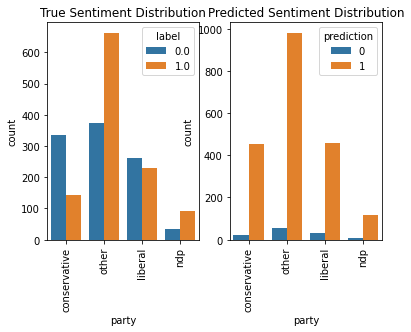

In [ ]:
# Plotting true sentiment and predicted sentiment
prediction = pd.DataFrame(data=y, columns=['prediction'] )
election_df = pd.concat([election_df, prediction], axis=1)

fig, ax =plt.subplots(1,2)
f = sns.countplot(data=election_df, x="party", hue="label", ax=ax[0])
f.set_xticklabels(f.get_xticklabels(), rotation=90)
f.set_title('True Sentiment Distribution')

f = sns.countplot(data=election_df, x="party", hue="prediction", ax=ax[1])
f.set_xticklabels(f.get_xticklabels(), rotation=90)
f.set_title('Predicted Sentiment Distribution')
plt.show()

#### Discussions: Whether NLP analytics based on tweets is useful for political parties during election?  

Although selected random forest model does not perform very well in terms of predicting negative sentiments and only achieves an accuracy of 52.84% on Election 2019 dataset. I think the main reasons for this low prediction accuracy is due to training set words cannot represent political sentiment very well. People tend to use specific terms with inferred sentiment when discussion a matter in a specific domain, in this case politics. If we gather more politics related training data, it will better represent political sentiment. 

Overall, I think NLP analysis is helpful and powerful when predicting social trends, even in a particular domain such as politics. However, when performing such analysis, we need to make sure our model is trained in a way so that it can represent characteristics of that knowledge domain. We can even further divide election analysis into finer groups such as specific campaign platform related, certain keywords related, hot topic related such as tax, housing and etc. We will get valuable insights of how people react to different parties' platform with these controversial topics in election period and then derive their political stands from there. As Internet has become a place where people live, shop, connect and state their opinions, NLP is a very sharp tool to analyzing trendings as long as it is utilized within legal boundaries.



### 4.2 Predict reasons of negative sentiment for Canadian Election 2019

Following steps are implemented to predict reasons for negative sentiment:

* **Data cleaning and precessing:**  
Negative tweets from Canadian Election 2019 dataset are extracted. It contains 10 reasons in total. However after examining negative reason distributions, it is observed that some reasons are rather infrequent, in order to balance dataset, I grouped reasons representing controversal topics among parties such as climate, healthcare, separation, women right and racisim into a new reason class named 'Controversy Topics'. Eventually, 4 reason classes are considered in this analysis. Moreover, categorical reason data is converted to numerical using sklearn label encoder.  

* **Test/train splitting:**  
Dataset is splitted into 70% training set and 30% testing set. The text data is vectorized using TF-IDF. TF-IDF model is trained on training set.  

* **Feature Importance**  
A feature correlation heatmap is plotted to visualize importance of selected words.

* **Model implemention:**  
As for the models, I implemented 3 algorithms including multi-class logistic regression, decision trees and random forest. Each of which was tuned using RandomSearchCV. 

* **Model performance visualization:**  
To demonstrate performance of each mode, accuracy and MSE on test set as well as accuracy on training are printed. Moreover, a classification report is generated for each model. To visualize distributions of prediction classes and true classes, a histgram figure is shown for each model as well.

**Model selection**

Performance of the best tuned model for each algorithm is shown in this table below:  

| Model               |Accuracy on Train | Accuracy on Test| MSE on Test|
| ------------        | ---------------  | --------------- |------------|
| Logistic Regression |0.6989            |0.5265           |1.1159      |
| Decision Tree       |0.8182            |0.4901           |1.2212      |
| Random Forest       |0.9247            |0.5132           |1.1026      |

Logistic regression model has higher test accuracy than random forest and random forest achieves slightly smaller test MSE. Random forest outperformed decision tree as the nature of this model is to ensemble decision trees in order to provide more generalized and robust results. However, it is overfitting training set with an accuracy of 92.47% due to its nature of handling large varieties of input data. Finally, the selected model is multi-class logistic regression with accuracy of 52.65%. 


#### Visualize distribution of negative reasons

There are 10 reasons for negative sentiment. Some infrequent reasons are grouped together in this step.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

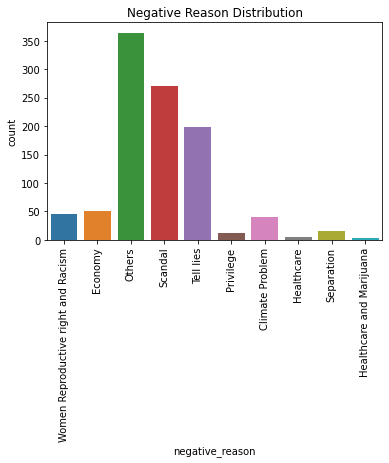

In [20]:
# Predict reason of negative sentiment
negative_election_df = election_df[election_df['sentiment']=='negative']
sns.countplot(x='negative_reason', data=negative_election_df)
plt.title('Negative Reason Distribution')
plt.xticks(rotation=90)

#### Re-categorize reasons to fewer classes and encode reasons to numerical


Others                364
Scandal               270
Tell lies             198
Controversy Topics    174
Name: negative_reason, dtype: int64


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Negative Reason Distribution After Grouping')

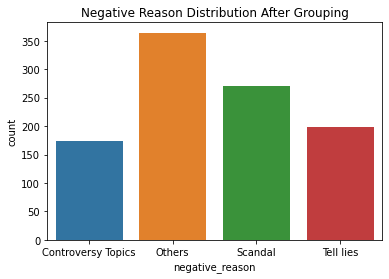

In [21]:
negative_reason_counts = negative_election_df.negative_reason.value_counts()
value_mask = negative_election_df.negative_reason.isin(negative_reason_counts.index[negative_reason_counts < 100])
negative_election_df.loc[value_mask,'negative_reason'] = "Controversy Topics"
print(negative_election_df.negative_reason.value_counts())

le = preprocessing.LabelEncoder()
le.fit(negative_election_df['negative_reason'])
negative_election_df['reason_class'] = le.transform(negative_election_df['negative_reason'])

sns.countplot(x='negative_reason', data=negative_election_df)
plt.title('Negative Reason Distribution After Grouping')

#### Prepare data including train/test splitting and vectorizing using TF-IDF

In [22]:
# Splt data into 70% training and 30% testing
X_ca = negative_election_df['clean_txt']
y_ca = negative_election_df['reason_class']
X_train_ca, X_test_ca, y_train_ca, y_test_ca = train_test_split(X_ca, y_ca, test_size=0.3, random_state=7)

In [23]:
# TF-IDF embedding
from sklearn.feature_extraction.text import TfidfVectorizer
tfIdfVectorizer = TfidfVectorizer(use_idf=True, max_features=1500, min_df=10, max_df=0.7)
X_train_tfidf_ca = tfIdfVectorizer.fit_transform(X_train_ca)
print(tfIdfVectorizer.get_feature_names())
print(len(tfIdfVectorizer.get_feature_names()))
tfidf_df_ca = pd.DataFrame(X_train_tfidf_ca.toarray(), columns = tfIdfVectorizer.get_feature_names())

['abortion', 'agree', 'alberta', 'american', 'andrew', 'andy', 'answer', 'ask', 'away', 'ba', 'bad', 'bandrew', 'believe', 'bernier', 'bi', 'bif', 'big', 'bring', 'bscheer', 'bthe', 'bthis', 'bxe', 'campaign', 'canada', 'canadavotes', 'canadian', 'candidate', 'canpoli', 'care', 'cbc', 'cdnelxn', 'cdnmedia', 'cdnpoli', 'change', 'chooseforward', 'claim', 'climate', 'come', 'comment', 'conservative', 'consultant', 'corruption', 'country', 'cpc', 'day', 'democracy', 'deserve', 'destroy', 'dirty', 'doesnxe', 'donxe', 'election', 'fact', 'fake', 'federal', 'fight', 'firm', 'fx', 'fxa', 'good', 'government', 'green', 'guy', 'hire', 'hold', 'issue', 'itxe', 'ixe', 'job', 'justin', 'kinsella', 'kinsellagate', 'know', 'leader', 'let', 'liar', 'liberal', 'lie', 'like', 'little', 'look', 'lose', 'lot', 'lpc', 'man', 'mean', 'medium', 'minister', 'monday', 'money', 'ncdnpoli', 'ndp', 'need', 'nelxn', 'new', 'news', 'nn', 'nncdnpoli', 'nnelxn', 'party', 'pay', 'people', 'plan', 'platform', 'pm', 'p

Compute feature importance by calculating correlations between each words and negative reason class. Selected top 159 words from TF-IDF vectorizer are calculated.

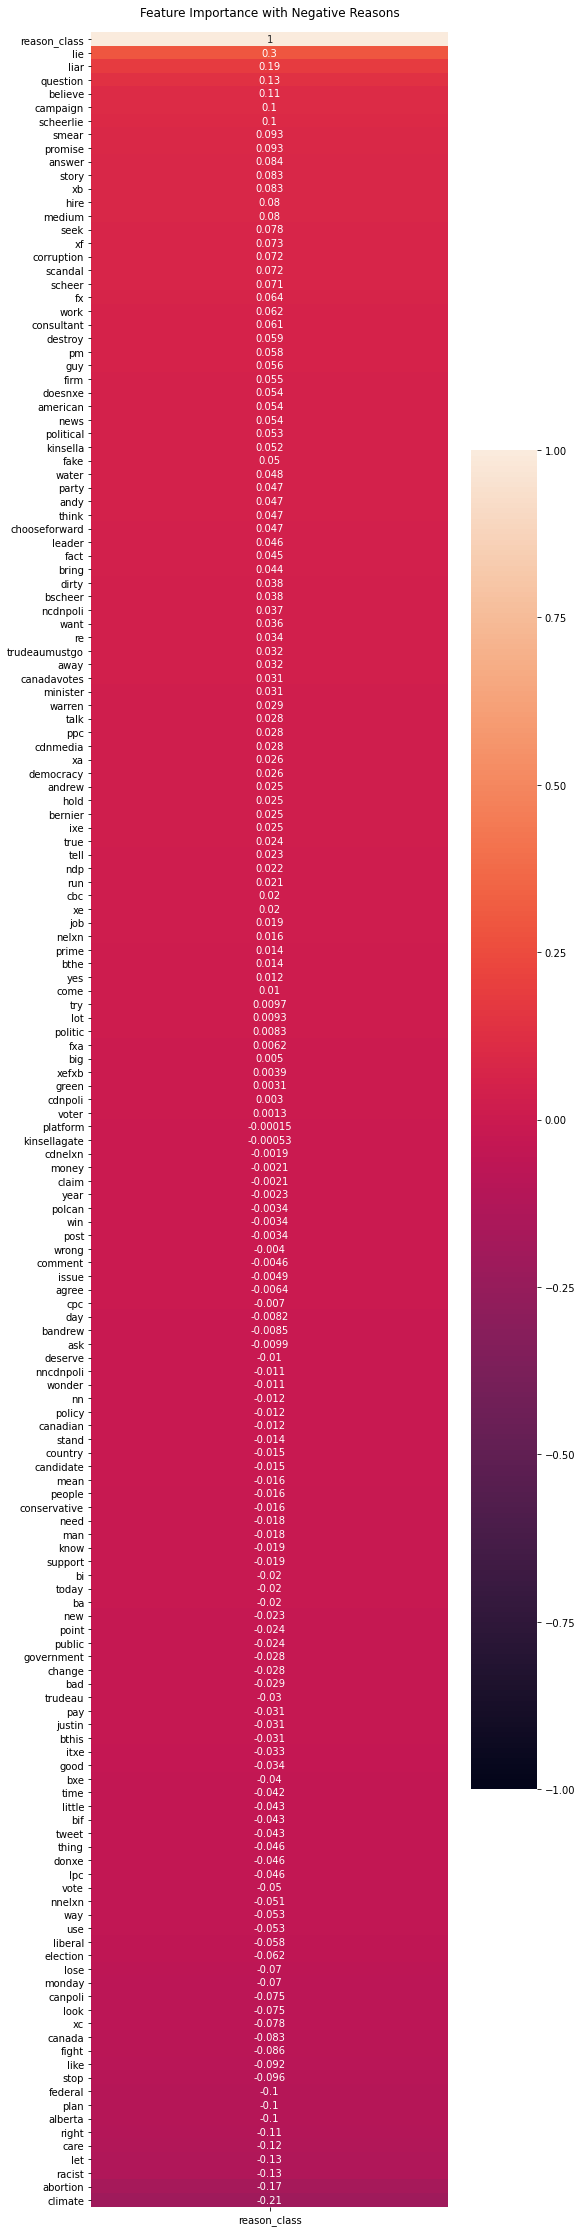

In [25]:
# Feature importance regarding negative reasons
fi_df = pd.DataFrame(X_train_tfidf_ca.toarray(), columns = tfIdfVectorizer.get_feature_names())
fi_df.reset_index(drop=True, inplace=True)
y_train_ca.reset_index(drop=True, inplace=True)
fi_df = pd.concat([fi_df, y_train_ca], axis=1)

plt.figure(figsize=(8,40))
heatmap = sns.heatmap(fi_df.corr()[['reason_class']].sort_values(by='reason_class', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Feature Importance with Negative Reasons', pad=16);

In [ ]:
# Process Testing set
x_test_tfidf_ca = tfIdfVectorizer.transform(X_test_ca)
x_test_tfidf_df_ca = pd.DataFrame(x_test_tfidf_ca.toarray(), columns = tfIdfVectorizer.get_feature_names())

In [ ]:
# Validate on test set and visualize classification result
def predict_and_plot(model, model_name):
    y = model.predict(x_test_tfidf_df_ca)

    print(model_name + ' - TF-IDF')
    print('---------------------------------------------------')
    print('Training set accuracy: {}'.format(model.score(tfidf_df_ca, y_train_ca)))
    print('Testing set accuracy:  {}'.format(accuracy_score(y_test_ca, y)))
    print('Testing set MSE:       {}'.format(mean_squared_error(y_test_ca, y)))
    print('Classification report')
    print('---------------------------------------------------')
    print(classification_report(y_test_ca, y))

    fig = sns.distplot(y)
    sns.distplot(y_test_ca)
    plt.title(model_name + ' Distribution of Predictions and True Classes')
    fig.legend(labels=['Prediction','True reason class'])
    plt.show()


#### Building models

Three models are implemented and tuned using RandomSearchCV:

* **Logistic Regression**



{'solver': 'newton-cg', 'C': 1}
Multi-class Logistic Regression - TF-IDF
---------------------------------------------------
Training set accuracy: 0.6988636363636364
Testing set accuracy:  0.5264900662251656
Testing set MSE:       1.1158940397350994
Classification report
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.59      0.34      0.43        56
           1       0.49      0.72      0.59       116
           2       0.57      0.51      0.54        76
           3       0.57      0.31      0.40        54

    accuracy                           0.53       302
   macro avg       0.55      0.47      0.49       302
weighted avg       0.54      0.53      0.51       302



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


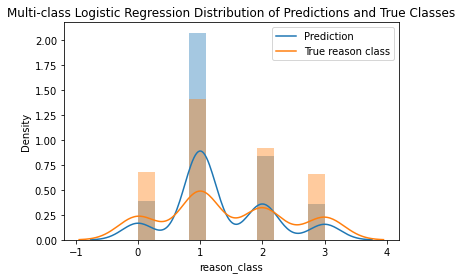

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {'solver': ['lbfgs', 'newton-cg', 'sag'],
              'C': [0.001, 0.1, 1, 10]}
clf = LogisticRegression(max_iter=50000, multi_class='multinomial', penalty='l2')
random_search_lr = RandomizedSearchCV(clf, param_distributions=param_dist, random_state=7)
random_search_lr.fit(tfidf_df_ca, y_train_ca)
print(random_search_lr.best_params_)

predict_and_plot(random_search_lr, 'Multi-class Logistic Regression')

This is the best performed model, hence I concat the predictions back to original dataframe to analyze reasons for failed predictions.

In [ ]:
# Concat predicted class to dataframe for best performed model
whole_ds = tfIdfVectorizer.transform(X_ca)
whole_ds_df = pd.DataFrame(whole_ds.toarray(), columns = tfIdfVectorizer.get_feature_names())

y_pred = random_search_lr.predict(whole_ds_df)
reason_pred = pd.DataFrame(data=y_pred, columns=['reason_predict'])
negative_election_df.reset_index(drop=True, inplace=True)
reason_pred.reset_index(drop=True, inplace=True)

negative_election_df = pd.concat([negative_election_df, reason_pred], axis=1)
# negative_election_df.to_csv('/content/drive/MyDrive/Colab Notebooks/1624 A3/reason_classify.csv', index=False)

* **Decision tree**

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'max_depth': 30}
Decision Tree - TF-IDF
---------------------------------------------------
Training set accuracy: 0.8181818181818182
Testing set accuracy:  0.4900662251655629
Testing set MSE:       1.2218543046357615
Classification report
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.44      0.36      0.40        56
           1       0.49      0.73      0.59       116
           2       0.48      0.34      0.40        76
           3       0.55      0.31      0.40        54

    accuracy                           0.49       302
   macro avg       0.49      0.44      0.45       302
weighted avg       0.49      0.49      0.47       302



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


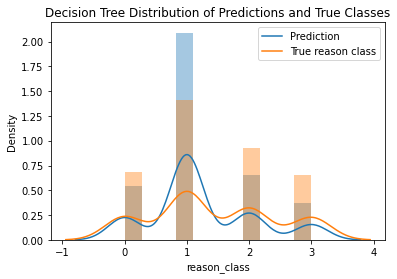

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
param_dist = {'max_depth': [4,8,15,30,40,45]}
clf = DecisionTreeClassifier()
random_search_dt = RandomizedSearchCV(clf, param_distributions=param_dist, random_state=7, scoring='accuracy')
random_search_dt.fit(tfidf_df, y_train)
print(random_search_dt.best_params_)

predict_and_plot(random_search_dt, 'Decision Tree')

* **Random Forest**

{'n_estimators': 250, 'max_depth': 35}
Random Forest - TF-IDF
---------------------------------------------------
Training set accuracy: 0.9247159090909091
Testing set accuracy:  0.5132450331125827
Testing set MSE:       1.1026490066225165
Classification report
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.16      0.25        56
           1       0.48      0.80      0.60       116
           2       0.58      0.49      0.53        76
           3       0.57      0.30      0.39        54

    accuracy                           0.51       302
   macro avg       0.54      0.44      0.44       302
weighted avg       0.53      0.51      0.48       302



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


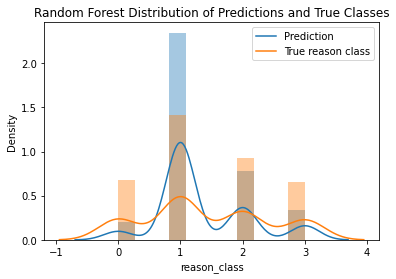

In [ ]:
# Ensemble: Random Forest
from sklearn.model_selection import RandomizedSearchCV
param_dist = {'n_estimators': [50,100,150,200,250,300],
              'max_depth': [12,15,30,35,40,45,50,55,60]}
clf = RandomForestClassifier()
random_search_rf = RandomizedSearchCV(clf, param_distributions=param_dist, random_state=7, scoring='accuracy')
random_search_rf.fit(tfidf_df, y_train)
print(random_search_rf.best_params_)

predict_and_plot(random_search_rf, 'Random Forest')

## Part 5: Results
### Sentiment Analysis Model  
To answer the research question: What can public opinion on twitter tell us about the Canadian political landscape in 2019? We can examine sentiment distributions for each party. From the figures from previous sections, we can see that liberal party and conservatice party have pretty much the same amount of discussions, however, more conservative party related discussions tend to be negative. Therefore liberal party could have a slightly better sentiment in public eye. Interestingly, this conform with the actual result of 2019 election where conservative and liberal got similar amount of popular votes. On the other hand, although NPD party has less tweets associated, percentage of positive tweets is higher than other parties, hence we can conclude that NPD has a positive reputation in public eye.  

  To improve our model performance, we can examine performance of our model trained from generic tweets dataset. It is observed that the best model trained on generic tweets dataset with 90% validation accuracy can only achieve 60% accuracy when predicting sentiment of Canadian Election dataset. The accuracy is relatively lower, I think the reason is that words from generic tweets set cannot represent political discussions very well as people tend to use a specific set of political terms which has dedicated sentiment meanings. Moreover, in some tweets, people use youtube links to express their opinion which will not be caught by our model. To obtain a better accuracy, we could collect more political or election related tweets with sentiment labels to use as training set. Also, we can perform k-fold cross validation to improve accuracy. Lastly, we can explore more powful models such as neural network with pretrained word embeddings.

### Negative Reason Classificasion Model  
As for the second model, the best performed model is multi-class logistic regression with a test set accuracy of 52.65% and MSE of 1.1159. Distribution of predicted reasons and true reasons are shown in previous section. This model fail badly to predict negative reasons for 'Others' class.  
The reasons could be, firstly, it is a group with mixed reasons and some of it contains confusing keywords which leads to mis-classification. The following example is labeled 'Others' but is classified as 'Tell Lie' because keyword 'lie' appears:
  > b'@JeffreyLuscombe @smittycanada1 @AndrewScheer @CBCKatie Yeah, the drink time is a pause to think - how will I spin this? Can I spin it? NO. Okay - deflect, redirect and if necessary, just flat out lie and gaslight. Unfit to lead. #cdnpoli #elxn43 #ChooseForward #ScheerLies'  

or
  > b'@CBCKatie You lie. "If they are not going to raise the GST, they\'d have to explain which taxes they will raise to pay for it. That is my challenge to Justin Trudeau today," Scheer said. #cdnpoli #cdnmedia #elxn43'

  Secondly, it cannot distinguish between 'Others' and 'Scandals' because both may contain similar keywords. 77 records in 'Scandals' class are mis-classified to be 'Others'. And 45 records in 'Others' are predicted to be 'Scandals' such as:
> 'b'@EdtheSock @lamullr Yup, seen him on the #WalkingDead. #Kinsella, Dirty Deeds Done Dirt Cheap! #ScheerLies #elxn43 #cdnpoli #ACDC https://t.co/mcCVptGDfj''  

or
> b'@RobynUrback Another self-aggrandizing @CBCNews media minion claiming moral superiority. #elxn43 #cdnpoli #cdnpoli'

  Keywords such as 'dirty' and media related appear many times so that it is classified into scandal.

  In order to improve performance of this model, we could first gather more training data points, secondly perform k-fold cross validation during training. Thirdly, we could try break down 'Others' class into finer reason classes. We could also explore more powerful text classifications models using neural network and with pretrained word embeddings.



## Part 6: Bonus

To explore this sentiment problem further, as the bonus section, I explored a self-trained word embeddings built with a neural network using Keras library. And use this model to predict sentiment of Canadian Election 2019 dataset.  

Firstly, I tried using the same TF-IDF vectorizer from previous part as benchmarking. Neural network is built with 10 node with relu activation function and sigmoid for output layer. Binary crossentropy is selected as loss function, optimizer is adman and metrics is accuracy. This model achieved a 95.65% acucracy on training set and 94.41% on testing. This model achieved 60.76% on Canadian Election dataset, which beats the best random forest model selected in previous steps which has 52.65% accuracy. Training/tesing accuracy and loss are plotted in figures below. The figures shows loss is not increasing and accuracy on both training and testing are similar which means that model is not overfitting, however it still can only get 60.76% on Canadian Election dataset. This proves the point that words in generic dataset cannot represent election dataset very well. 

Secondly, I tried to add a embedding layer to train neural network to create a word embedding itself. In addition to this, I also add a convolution layer to make this neural network to better understanding context and order of words. This model achieves 97.13% accuracy on training set, 96.10% on testing set and 61.37% when predicting on Canadian Election set which is slightly better than previous neural network.

To sum up, convolutional netural network model beats all other models and achieve 61.37% of accuracy on predicting sentiment for Canadian Election 2019 dataset.

### Neural network with TF-IDF embedding

* **Building model**




In [ ]:
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session

# Number of features
input_dim = X_train_tfidf.shape[1]

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train_tfidf.toarray(), y_train, epochs=50, verbose=False, validation_split=0.2, batch_size=1000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                15010     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 15,021
Trainable params: 15,021
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [ ]:
clear_session()

* **Training model, validate on test set and visualizing accuracy and loss**

Training Accuracy: 0.9465
Testing Accuracy:  0.9441


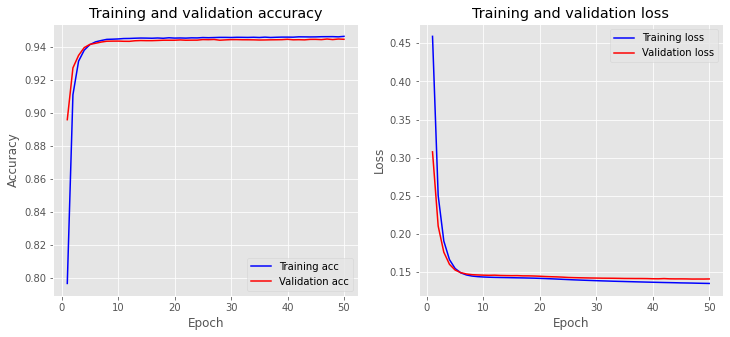

In [ ]:
loss, accuracy = model.evaluate(X_train_tfidf.toarray(), y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test_tfidf.toarray(), y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

* **Prediction sentiment for Canadian Election 2019 dataset**

This neural network model achieved 60.76% when prediction sentiment for Canadian Election 2019 dataset.

In [ ]:
loss, accuracy = model.evaluate(canadian_election.toarray(), y_real, verbose=False)
print("Canadian Election Dataset Accuracy: {:.4f}".format(accuracy))

Canadian Election Dataset Accuracy: 0.6076


### Neural network with self-trained word embedding layer


In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
# print(X_train[2])
# print(X_train_tok[2])

In [ ]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 100
X_train_tok = pad_sequences(X_train_tok, padding='post', maxlen=maxlen)
X_test_tok = pad_sequences(X_test_tok, padding='post', maxlen=maxlen)
# print(X_train_tok[0:10])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           8487350   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           32128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 8,520,779
Trainable params: 8,520,779
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.9713
Testing Accuracy:  0.9610


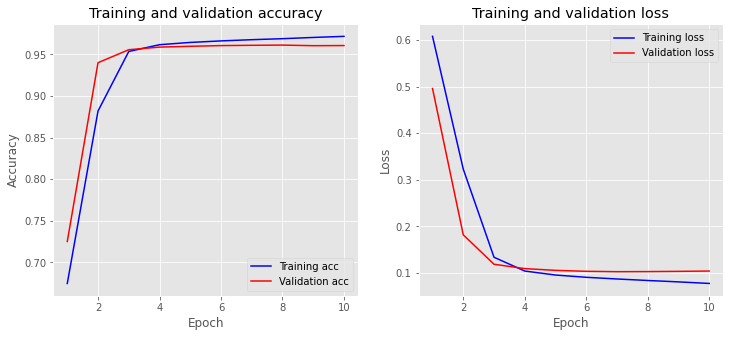

In [ ]:
# NN model with embedding layer
embedding_dim = 50

clear_session()
model_em = Sequential()
model_em.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim,
                           input_length=maxlen))
# model_em.add(layers.Flatten())
model_em.add(layers.Conv1D(128, 5, activation='relu'))
model_em.add(layers.GlobalMaxPool1D())
model_em.add(layers.Dense(10, activation='relu'))
model_em.add(layers.Dense(1, activation='sigmoid'))
model_em.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_em.summary()

history = model_em.fit(X_train_tok, y_train, epochs=10, verbose=False, validation_split=0.2, batch_size=10000)
loss, accuracy = model_em.evaluate(X_train_tok, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_em.evaluate(X_test_tok, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

* **Prediction sentiment for Canadian Election 2019 dataset**

This convo neural network model achieved 61.37% when prediction sentiment for Canadian Election 2019 dataset.

In [ ]:
canadian_election_tok = tokenizer.texts_to_sequences(election_df['clean_txt'])
canadian_election_tok = pad_sequences(canadian_election_tok, padding='post', maxlen=maxlen)
loss, accuracy = model_em.evaluate(canadian_election_tok, y_real, verbose=False)
print("Canadian Election Dataset Accuracy: {:.4f}".format(accuracy))

Canadian Election Dataset Accuracy: 0.6137
